In [1]:
from google.colab import drive

# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input



In [3]:
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split

# Chemin vers le répertoire contenant votre ensemble de données sur Google Drive
dataset_dir = '/content/drive/MyDrive/flowers'

# Créer les répertoires pour l'entraînement, la validation et le test
base_dir = '/content/drive/MyDrive/flower_dataset_splitted'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Copier les images dans les répertoires d'entraînement, de validation et de test
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    images = os.listdir(class_path)

    # Vérifiez si la taille de l'ensemble d'entraînement est suffisamment grande
    if len(images) < 2:
        continue

    train_images, test_val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Vérifiez si la taille de l'ensemble de validation et de test est suffisamment grande
    if len(test_val_images) < 2:
        continue

    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    # Créez des sous-répertoires par classe dans les ensembles d'entraînement, de validation et de test
    train_class_dir = os.path.join(train_dir, class_folder)
    os.makedirs(train_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_folder)
    os.makedirs(val_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_folder)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in train_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dest_path)

    for img in val_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(val_class_dir, img)
        shutil.copy(src_path, dest_path)

    for img in test_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dest_path)

# Vérifiez le nombre d'images dans chaque sous-répertoire des ensembles d'entraînement, de validation et de test
print(f"Train Set: {sum(len(os.listdir(os.path.join(train_dir, class_folder))) for class_folder in os.listdir(train_dir))} images")
print(f"Validation Set: {sum(len(os.listdir(os.path.join(val_dir, class_folder))) for class_folder in os.listdir(val_dir))} images")
print(f"Test Set: {sum(len(os.listdir(os.path.join(test_dir, class_folder))) for class_folder in os.listdir(test_dir))} images")



Train Set: 3464 images
Validation Set: 433 images
Test Set: 435 images


In [4]:
input_shape = (224, 224, 3)
num_classes = 5
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/flower_dataset_splitted/train',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/flower_dataset_splitted/val',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/flower_dataset_splitted/test',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)


Found 3464 images belonging to 5 classes.
Found 433 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Load the pre-trained VGG16 model
pre_model = VGG16(weights='imagenet', include_top=True)

# Freeze the weights of the base model to avoid modifying them during training
# Freeze the pre-trained layers
for layer in pre_model.layers:
    layer.trainable = False

x = Flatten()(pre_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Adding dropout layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Adding dropout layer
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Adding dropout layer
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=pre_model.inputs, outputs=x)

# Display a summary of the model's architecture
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# Train the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 5, restore_best_weights = True)
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    batch_size = batch_size,
    callbacks =[earlystopping],
    verbose = 1
)
# save the model
model.save('model/VGG16_model.h5')

Epoch 1/10
109/109 [==============================] - 83s 664ms/step - loss: 1.9120 - accuracy: 0.4616 - val_loss: 1.3610 - val_accuracy: 0.5404
Epoch 2/10
109/109 [==============================] - 70s 647ms/step - loss: 1.3046 - accuracy: 0.5930 - val_loss: 1.1590 - val_accuracy: 0.6490
Epoch 3/10
109/109 [==============================] - 66s 609ms/step - loss: 1.2252 - accuracy: 0.6233 - val_loss: 1.1568 - val_accuracy: 0.6513
Epoch 4/10
109/109 [==============================] - 69s 633ms/step - loss: 1.1575 - accuracy: 0.6568 - val_loss: 1.0675 - val_accuracy: 0.6975
Epoch 5/10
109/109 [==============================] - 66s 606ms/step - loss: 1.1386 - accuracy: 0.6620 - val_loss: 1.0072 - val_accuracy: 0.7298
Epoch 6/10
109/109 [==============================] - 67s 618ms/step - loss: 1.1320 - accuracy: 0.6585 - val_loss: 1.0390 - val_accuracy: 0.7136
Epoch 7/10
109/109 [==============================] - 67s 611ms/step - loss: 1.1017 - accuracy: 0.6822 - val_loss: 1.0317 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 12s 860ms/step - loss: 1.1329 - accuracy: 0.6483
Test Loss: 1.1329371929168701
Test Accuracy: 0.6482758522033691


In [10]:
from google.colab import files
files.download('/content/model/VGG16_model.h5')  # Example path

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

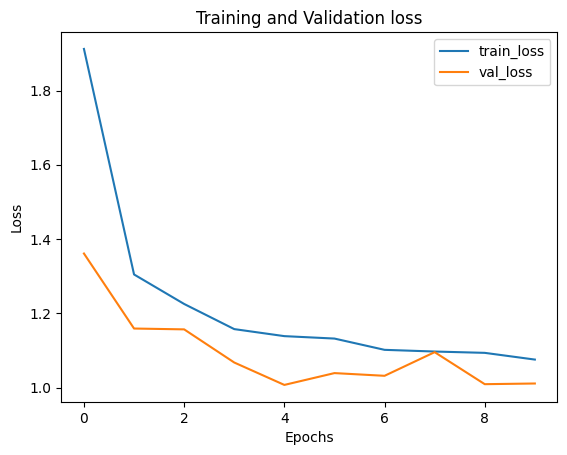

In [11]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

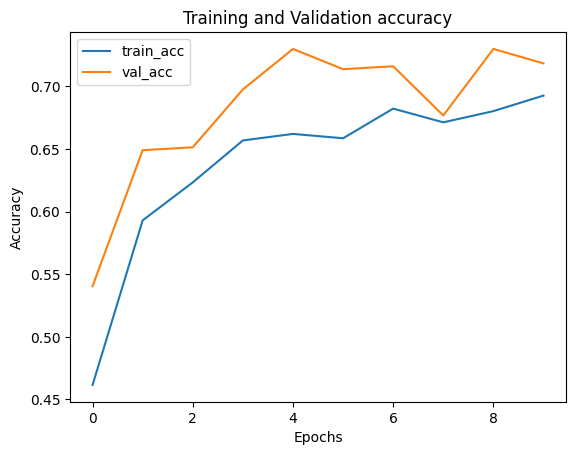

In [12]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Evaluation
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model = load_model('model/VGG16_model.h5')

# Get the true labels for the test set
y_true = test_generator.classes
# Get the class indices
class_indices = test_generator.class_indices

# Convert the class indices to class names
class_names = list(class_indices.keys())

# Use the model to predict the labels for the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# y_true and y_pred are true and predicted labels
print(classification_report(y_true, y_pred, target_names=class_names))


14/14 [==============================] - 7s 473ms/step
              precision    recall  f1-score   support

       daisy       0.73      0.61      0.67        77
   dandelion       0.84      0.78      0.81       106
        rose       0.81      0.54      0.65        79
   sunflower       0.52      0.74      0.61        74
       tulip       0.65      0.75      0.69        99

    accuracy                           0.69       435
   macro avg       0.71      0.69      0.69       435
weighted avg       0.72      0.69      0.70       435



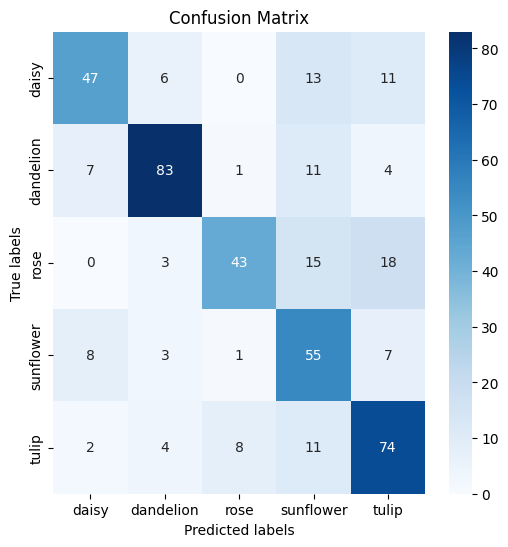

In [14]:
import seaborn as sns

# Assuming confusion_matrix and class_names are defined somewhere in your code

# Compute confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()